# E20 프로젝트: 다른 시계열 데이터에서 이상치를 찾아보자

## 데이터 구하기
나스닥으로 해봅시다.

In [5]:
import pandas as pd
import numpy as np

In [6]:
# 저장한 csv를 읽어옵니다.
csv_file = './data/NQMAX.csv'
df = pd.read_csv(csv_file)
df.head(2)

Date    Open    High     Low   Close  Adj Close   Volume
0  2000-09-18  3721.0  3785.5  3602.0  3653.5     3653.5  72994.0
1  2000-09-19  3658.5  3817.0  3656.0  3804.0     3804.0  70029.0

## 기본 통계분석으로 이상치 찾기

- 데이터의 분포를 그려보기
- z-test로 정규분포를 만족하는지 확인하기
- (정규분포를 만족하지 않으면) Time series decompose 수행후 residual로 분석하기

### 한 단계 더 나아가기
- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이상치들을 제거/교정해야할지 내버려둘지 고민하기

In [7]:
# 날짜데이터를 Datetime 형식으로 바꿔줍니다.
df.loc[:,'Date'] = pd.to_datetime(df.Date)

# 데이터의 정합성을 확인합니다
df.isna().sum()

Date            0
Open         1072
High         1072
Low          1072
Close        1072
Adj Close    1072
Volume       1072
dtype: int64

결측치 1072개!   
일단 삭제하는 방법으로 진행하자

### 결측치 삭제

In [8]:
print("삭제 전 데이터 길이(일자수):",len(df))
df = df.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 길이(일자수):",len(df))
df.isna().sum()

삭제 전 데이터 길이(일자수): 6166
삭제 후 데이터 길이(일자수): 5094


Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### 데이터 분포 그려보기

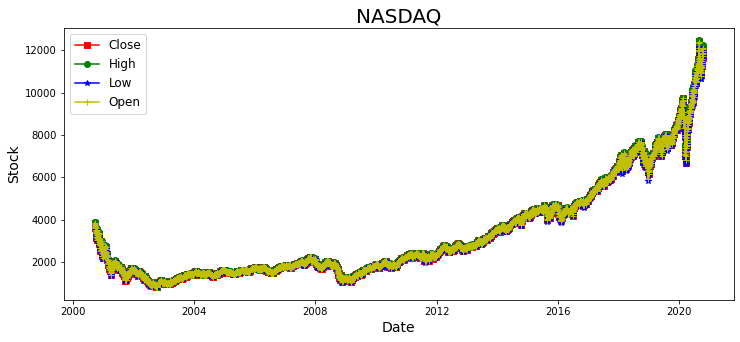

In [13]:
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

plt.rcParams["figure.figsize"] = (12,5)
# Line Graph by matplotlib with wide-form DataFrame

plt.plot(df.Date, df.Close, marker='s', color='r')
plt.plot(df.Date, df.High, marker='o', color='g')
plt.plot(df.Date, df.Low, marker='*', color='b')
plt.plot(df.Date, df.Open, marker='+', color='y')

plt.title('NASDAQ', fontsize=20) 
plt.ylabel('Stock', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=12, loc='best')

plt.show()

### 종가 데이터로 z-test 수행해보기

In [14]:
from statsmodels.stats.weightstats import ztest
_, p = ztest(df.Close)
print(p)

0.0


종가 데이터는 정규 분포와는 거리가 먼 것으로 파악된다.

### Time series decompose 수행후 residual로 분석

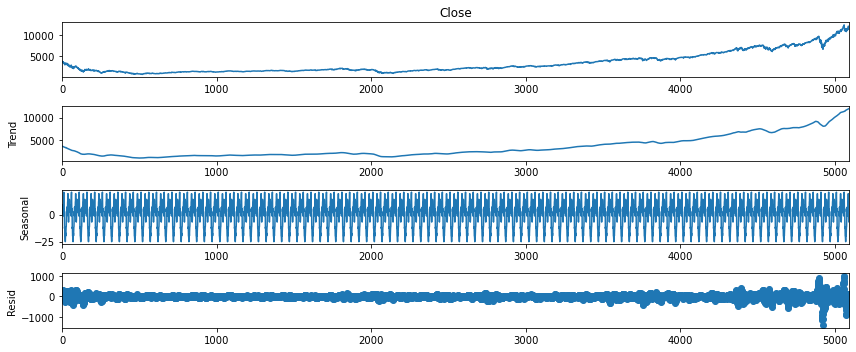

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df.Close, model='additive', two_sided=True, 
                            period=50, extrapolate_trend='freq') # 계절적 성분 50일로 가정
result.plot()
plt.show()

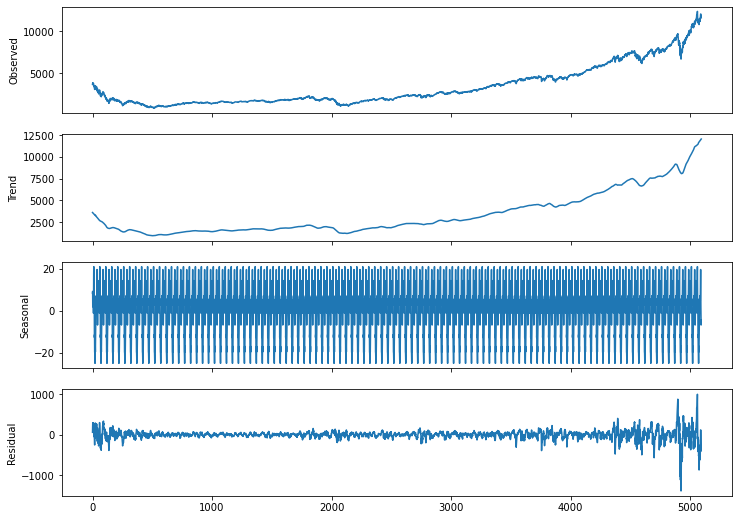

In [16]:
#그래프가 너무 작아서 안보인다면

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(12,9))
result.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
result.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
result.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
result.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
plt.show()

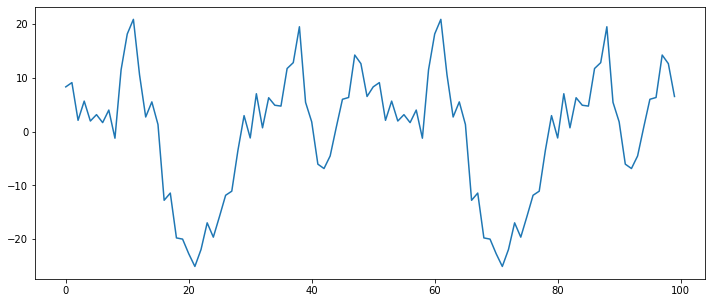

In [17]:
# seasonal 성분은 너무 빼곡하게 보이네요. 다시 확인해보겠습니다.
result.seasonal[:100].plot()

-25 에서 20 정도 사이를 주기적으로 반복한다.   
residual의 분포를 그려보자

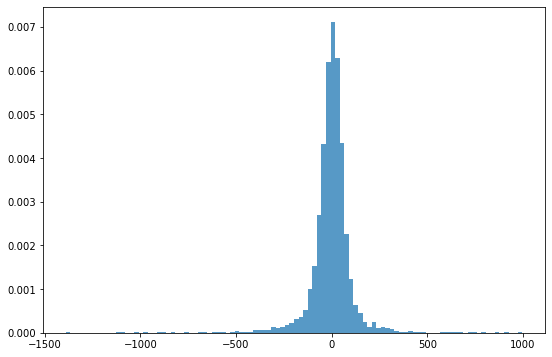

In [18]:
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

좀 정규분포처럼 생겼다!

In [19]:
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.8942734929026335 0.3711755787583094


p-value 도 0.05를 훨씬 상회하는 값을 나타낸다. Residual 값은 정규분포를 따른다고 볼 수 있을 것 같다.

### 3σ  기준 신뢰구간으로 이상치 찾기

In [28]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))
print('idx',result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index)
for date in df.Date[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index]:
    print(date)


평균: -1.3857940518773681 표준편차: 110.60068205120825
이상치 갯수: 93
idx Int64Index([  66,   73,   91,   92,  136,  137, 3757, 3758, 4373, 4374, 4393,
            4394, 4408, 4554, 4577, 4590, 4591, 4593, 4596, 4696, 4698, 4699,
            4700, 4701, 4742, 4890, 4891, 4892, 4893, 4894, 4895, 4896, 4897,
            4898, 4899, 4900, 4901, 4909, 4913, 4916, 4918, 4919, 4920, 4921,
            4922, 4923, 4924, 4925, 4926, 4927, 4929, 4930, 4933, 4934, 4935,
            4942, 4943, 4944, 4945, 4946, 5005, 5015, 5016, 5028, 5030, 5053,
            5054, 5055, 5056, 5057, 5058, 5059, 5060, 5061, 5062, 5064, 5067,
            5071, 5072, 5073, 5074, 5075, 5076, 5077, 5078, 5079, 5080, 5082,
            5083, 5084, 5085, 5086, 5093],
           dtype='int64')
2000-12-20 00:00:00
2001-01-02 00:00:00
2001-01-29 00:00:00
2001-01-30 00:00:00
2001-04-03 00:00:00
2001-04-04 00:00:00
2015-08-24 00:00:00
2015-08-25 00:00:00
2018-02-08 00:00:00
2018-02-09 00:00:00
2018-03-09 00:00:00
2018-03-12 00:00:00
201

2001년 1월말, 2015년 8월말, 2018년 3월초, 2018년 12월말, 2019년 5월말, 2020년 2월중순, 2020년 3월, 4월, 8월, 9월, 10월이 집계되었다.   
2020년은 코로나 위기로 인한 것으로 생각된다. 2008년, 2009년이 집계되지 않은 것이 의아하다.

In [29]:
# 2001년 1월말에 무슨 일이 있었는지 살펴보자
# 2001-01-29 주변 정황
df.iloc[85:95]

Date    Open    High     Low   Close  Adj Close    Volume
85 2001-01-19  2720.0  2769.0  2657.0  2686.5     2686.5   86356.0
86 2001-01-22  2689.5  2712.0  2622.0  2683.0     2683.0   84234.0
87 2001-01-23  2675.0  2768.0  2641.5  2745.0     2745.0   78902.0
88 2001-01-24  2751.0  2797.0  2711.5  2714.5     2714.5   88366.0
89 2001-01-25  2708.5  2747.0  2605.5  2613.5     2613.5   93694.0
90 2001-01-26  2619.5  2663.0  2548.5  2645.5     2645.5  120230.0
91 2001-01-29  2630.0  2715.5  2593.0  2705.5     2705.5   60115.0
92 2001-01-30  2709.0  2736.5  2672.0  2697.5     2697.5   72285.0
93 2001-01-31  2694.0  2740.0  2600.0  2611.0     2611.0   83273.0
94 2001-02-01  2608.5  2647.5  2569.0  2627.5     2627.5   87703.0

앞 이틀, 뒤 이틀에 비해, 2001년 01월 29일, 30일의 종가는 높으면서 거래량은 낮은 형태를 보여주고 있다! 이런 형태는 Novelty 라고 판단할 수 있을 것 같다. 일반적인 주가 움직임과 조금은 다르지만, 그래도 주가가 움직이는 특별한 패턴을 설명한다고 볼 수 있기 때문에, 데이터에 포함하는 것이 좋다고 생각한다.

## Step 3. Unsupervised Clustering 으로 이상치 찾기
- k-means로 분석하기
- DBSCAN으로 분석하기

### 한 단계 더 나아가기
- 왜 이상치로 분류됐는지 해석해보기
- 탐지해낸 이상치(Anomalies)는 극단치(Outlier) 인지, 특이치(Novelties)인지 생각해보기
- 이 이상치를 제거/교정해야할지 내버려둘지 고민하기

## Step 4. LSTM 오토인코더로 이상치 찾기

- 딥러닝을 위한 데이터셋 만들기
- 오토인코더 모델 생성하기
- 학습이 정상적으로 수행됐는지 확인하기

### 한 단계 더 나아가기
- 앞선 두가지 방법과 비교하기
- 다른 이유가 뭔지 확인해보기
- 더 나은 형태의 오토인코더 모델을 만들어보기

# 결과보고서